Set OBSGEO-B to    -6.234627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1336593657.111 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-10T00:53:49.172' from MJD-AVG.
Set DATE-END to '2023-09-10T03:25:56.696' from MJD-END'. [astropy.wcs.wcs]
[INFO] 717 x 71 x 75 Cube (/Users/mary/Fits image of JWST/ngc6302_ch4-long_s3d.fits)
[INFO] .data(717 x 71 x 75) (MJy / sr), no noise
[INFO] center:(-37:06:12.736548,-06:46:15.65618616) size:(24.850",26.250") step:(0.350",0.350") rot:-0.0 deg frame:ICRS
[INFO] wavelength: min:24.40 max:28.70 step:0.01 um


Wavelength range in data cube: 24.40299961855635 - 28.69899965589866 μm
Filtered Wavelengths: [24.40299962 24.40899962 24.41499962 24.42099962 24.42699962 24.43299962
 24.43899962 24.44499962 24.45099962 24.45699962 24.46299962 24.46899962
 24.47499962 24.48099962 24.48699962 24.49299962 24.49899962 24.50499962
 24.51099962 24.51699962 24.52299962 24.52899962 24.53499962 24.54099962
 24.54699962 24.55299962 24.55899962 24.56499962 24.57099962 24.57699962
 24.58299962 24.58899962 24.59499962 24.60099962 24.60699962 24.61299962
 24.61899962 24.62499962 24.63099962 24.63699962 24.64299962 24.64899962
 24.65499962 24.66099962 24.66699962 24.67299962 24.67899962 24.68499962
 24.69099962 24.69699962 24.70299962 24.70899962 24.71499962 24.72099962
 24.72699962 24.73299962 24.73899962 24.74499962 24.75099962 24.75699962
 24.76299962 24.76899962 24.77499962 24.78099962 24.78699962 24.79299962
 24.79899962 24.80499962 24.81099962 24.81699962 24.82299962 24.82899962
 24.83499962 24.84099962 24.84

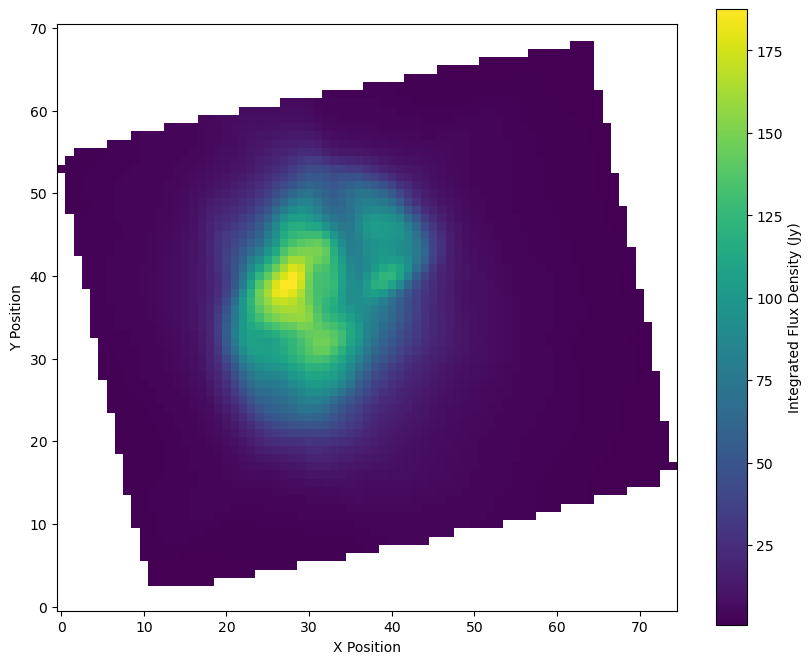

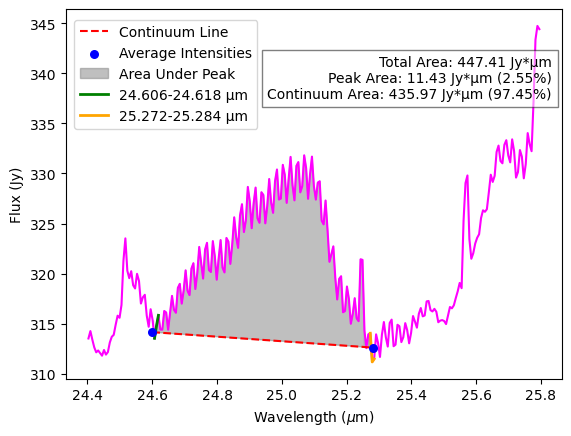

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from mpdaf.obj import Cube
from astropy.io import fits

obj1 = Cube('/Users/mary/Fits image of JWST/ngc6302_ch4-long_s3d.fits')
obj1.info()

pixel_size = obj1.wcs.get_step(unit=u.arcsec)[0] 
solid_angle = (pixel_size * u.arcsec).to(u.rad)**2

def process_slices_in_range(cube, solid_angle, wavelength_min, wavelength_max):
    wavelength = cube.wave.coord()
    print(f"Wavelength range in data cube: {wavelength.min()} - {wavelength.max()} μm")
    
    mask = (wavelength >= wavelength_min) & (wavelength <= wavelength_max)
    filtered_wavelengths = wavelength[mask]
    print(f"Filtered Wavelengths: {filtered_wavelengths}")
    
    integrated_flux_density_map = np.zeros((cube.shape[1], cube.shape[2]))
    for i in range(cube.shape[0]):
        if mask[i]:
            integrated_flux_density_map += cube.data[i, :, :] * solid_angle.value * 1e6

    if np.all(integrated_flux_density_map == 0):
        return

    plt.figure(figsize=(10, 8))
    plt.imshow(integrated_flux_density_map, cmap='viridis', origin='lower')
    plt.colorbar(label='Integrated Flux Density (Jy)')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'')
    plt.savefig('25integrated_flux_density_map_filtered.png', dpi=300, bbox_inches='tight')
    plt.show()

    filtered_flux_density = np.zeros(len(filtered_wavelengths))
    for i, wl in enumerate(filtered_wavelengths):
        filtered_flux_density[i] = np.sum(cube.data[mask][i, :, :]) * solid_angle.value * 1e6

  
    mask_start = (filtered_wavelengths >= 24.606) & (filtered_wavelengths <= 24.618)
    continuum_start = np.mean(filtered_flux_density[mask_start])

    mask_end = (filtered_wavelengths >= 25.272) & (filtered_wavelengths <= 25.284)
    continuum_end = np.mean(filtered_flux_density[mask_end])

    wavelengths = [24.60, 25.28]
    average_intensities = [continuum_start, continuum_end]

   
    continuum_line = np.interp(filtered_wavelengths, wavelengths, average_intensities)

    plt.figure()
    plt.plot(filtered_wavelengths, filtered_flux_density, color='magenta')
    plt.plot([24.60, 25.28], [continuum_start, continuum_end], label='Continuum Line', color='red', linestyle='--')
    plt.scatter(wavelengths, average_intensities, color='blue', s=30,zorder=5,label='Average Intensities')
 
 
    wavelength_condition = (filtered_wavelengths >= 24.60) & (filtered_wavelengths <= 25.28)

 
    plt.fill_between(filtered_wavelengths, filtered_flux_density, continuum_line, 
                     where=(filtered_flux_density > continuum_line) & wavelength_condition, 
                     color='gray', alpha=0.5, label='Area Under Peak')

    total_area = np.trapz(filtered_flux_density, filtered_wavelengths)
    continuum_area = np.trapz(continuum_line, filtered_wavelengths)
    peak_area = total_area - continuum_area

    peak_area_percentage = (peak_area / total_area) * 100
    continuum_area_percentage = (continuum_area / total_area) * 100

    annotation_text = (f'Total Area: {total_area:.2f} Jy*μm\n'
                       f'Peak Area: {peak_area:.2f} Jy*μm ({peak_area_percentage:.2f}%)\n'
                       f'Continuum Area: {continuum_area:.2f} Jy*μm ({continuum_area_percentage:.2f}%)')
    plt.annotate(annotation_text, xy=(0.98, 0.75), xycoords='axes fraction', fontsize=10, color='black',
                 ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.5))

    idx_22_2 = np.argmin(np.abs(filtered_wavelengths - 24.606))
    idx_22_4 = np.argmin(np.abs(filtered_wavelengths - 24.618))
    plt.plot(filtered_wavelengths[idx_22_2:idx_22_4 + 1], filtered_flux_density[idx_22_2:idx_22_4 + 1], color='green', linestyle='-', linewidth=2, label='24.606-24.618 μm')

    idx_23_9 = np.argmin(np.abs(filtered_wavelengths - 25.272))
    idx_24_1 = np.argmin(np.abs(filtered_wavelengths - 25.284))
    plt.plot(filtered_wavelengths[idx_23_9:idx_24_1 + 1], filtered_flux_density[idx_23_9:idx_24_1 + 1], color='orange', linestyle='-', linewidth=2, label='25.272-25.284 μm')
    plt.legend(loc='upper right', bbox_to_anchor=(0.4, 0.99))
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Flux (Jy)')
    plt.title('')
    plt.savefig('19111.png', dpi=300, bbox_inches='tight')
    plt.show()

process_slices_in_range(obj1, solid_angle, 24.40, 25.8)



